### CT Statewide House Sales Transactions
This notebook is exploring the data from https://data.ct.gov/Housing-and-Development/Real-Estate-Sales-2001-2016/5mzw-sjtu?category=Housing-and-Development , which lists CT statewide sales transactions on individual properties from 2001-2016.
* Note: this link includs a PDF that explains each of the NonUseCodes.

My GitHub repository: https://github.com/jamiekasulis/ct_real_estate_sales, where you can view
* The raw data file
* The notebook I used to clean that file
* The clean data files that I analyze here

### Potential Inquiries
* See where properties with multiple transactions gained and lost value --> (How many houses, how much value, by town, over different periods of time)
* Foreclosures-- where and when have there been a lot?
* Building of new developments? (Might be shown by selling many houses in a short period of time on a new road)
* Signs of house flipping, i.e. a purchase and a sale for significantly more within a short period
* Has recovery been different for different segments of the market (different price-range houses)?
* Are there observable effects of the crumbling fundations in the northeastern part of CT?

### Calculations
* Adjust sales prices for inflation/season -- there is a Python package for seasonal adjustment
* Take a close look at the assessment column
* Each town's assessment rate, or look at a hosue's sale ratio relative to its town only
* Distribution of house prices in given towns, or on given streets
* Town-by-town medians, ranges

### Themes
* Recovery

In [219]:
import pandas as pd
import matplotlib
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#### Update MAX_YEAR when new data comes out.

In [2]:
MIN_YEAR = 2001
MAX_YEAR = 2016 # update this when new data comes out

In [3]:
def combine_data_into_master_df():
    """
    Returns a DataFrame which combines all of the clean CSVs for each year.
    """
    # Combine the year-by-year clean csvs, which are located at 'data/clean_data_20xx_listings.csv'
    df = pd.read_csv('data/clean_data_' + str(MIN_YEAR) + '_listings.csv')
    for year in range(MIN_YEAR+1, MAX_YEAR+1):
        df = df.append(pd.read_csv('data/clean_data_' + str(year) + '_listings.csv'))

    # Now remove the index column
    #df = df.drop('Unnamed: 0', 1)
    return df

In [4]:
df = combine_data_into_master_df()
df.head()

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks
0,684,10173,2001,04/17/2002 12:00:00 AM,Ansonia,1-3 EAGLE STREET,63630,116000.0,54.853448,Residential,Two Family,0,NaN
1,694,10005,2001,10/04/2001 12:00:00 AM,Ansonia,1 CRESTWOOD ROAD,76370,160000.0,47.731250,Residential,Single Family,0,NaN
2,697,10253,2001,06/18/2002 12:00:00 AM,Ansonia,1 DAVIES CT,97720,180000.0,54.288889,Residential,Single Family,0,NaN
3,698,10094,2001,01/17/2002 12:00:00 AM,Ansonia,1 DOREL TER,110600,259900.0,42.554829,Residential,Single Family,0,NaN
4,710,10100,2001,01/30/2002 12:00:00 AM,Ansonia,1 JAMES STREET,63210,132000.0,47.886364,Residential,Single Family,0,NaN


In [ ]:
df.tail()

In [ ]:
# Make sure the IDs match the right rows from the original raw file
df.sort_values('ID') # Looks good

### Notes on the data frames
* Use DataFrame 'df' if you want to look at ALL of the data
* Use 'use_df' if you want to just look at the rows that don't have NonUseCodes. You should use use_df if you are calculating any statistics.
* Use 'res_df' if you want to look at RESIDENTIAL properties (but not condos or apartments) that don't have NonUseCodes. Best way to observe the real estate market in general.

In [5]:
def get_residential(df):
    """
    Returns just the residential properties.
    """
    return df[df['PropertyType'] == 'Residential']

def get_commercial(df):
    """
    Returns just the commercial properties.
    """
    return df[df['PropertyType'] == 'Commercial']

In [6]:
use_df = df[df['NonUseCode'] < 1]
res_df = get_residential(use_df)

In [7]:
# Check
use_df[use_df['NonUseCode'] != -1]
res_df[res_df['PropertyType'] != 'Residential']

,ID,SerialNumber,ListYear,DateRecorded,Town,Address,AssessedValue,SaleAmount,SalesRatio,PropertyType,ResidentialType,NonUseCode,Remarks


### Foreclosures-- where and when have there been a lot?
Note: In order for this analysis to be truthfully valuable, you should do some kind of adjustment. This might be very complicated. (Adjusting by population fails to weigh folks living in apartments, for example.)

In [ ]:
# How many foreclosures on properties 2001-2016?
foreclosures = df[df['NonUseCode'] == 14]
print("Number of properties that have been foreclosed on: %d" %len(foreclosures['Address'].unique()))

#### Make a function to return a DataFrame that ranks towns by most foreclosures.

In [ ]:
def count_foreclosures_by_town(df, town, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a subset of df of foreclosed properties from town.
    Is a helper function for make_foreclosures_by_town_dict()
    """
    # Make sure proper arguments passed
    if property_type not in ['Residential', 'Commercial', 'All']:
        raise Exception("Not a valid property_type.")
        return
    if years[0] < MIN_YEAR or years[1] > MAX_YEAR:
        raise Exception("Not a valid year range")
        return
    
    else:
        # Convert year range to a list of all years in that range
        years = list(range(years[0], years[1]+1))
    
    subset = df[(df['Town'] == town) & (df['ListYear'].isin(years)) & (df['NonUseCode'] == 14)]
    return subset

In [ ]:
def make_foreclosures_by_town_dict(df, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a dictionary with keys = town name and value = number of foreclosures.
    This function feeds make_rankings_df_from_dict.
    """
    foreclosure_ranks_by_town = {}
    for town in df['Town'].unique():
        if town not in foreclosure_ranks_by_town.keys():
            foreclosure_ranks_by_town[town] = len(count_foreclosures_by_town(df, town, years, property_type))
    return foreclosure_ranks_by_town

In [ ]:
def make_rankings_df_from_dict(dictionary, value_name):
    """
    Makes a dataframe out of a dictionary. First column name is 'Town' and second is value_name.
    dictionary should be produced by an explicit call to make_foreclosures_by_town_dict.
    """
    df = pd.DataFrame.from_dict(data=dictionary, orient='index') # make initial df
    df['Town'] = df.index # pull index out into its own column
    df.columns = [value_name, 'Town'] # Set column names
    df = df[['Town', value_name]] # Reorder the columns
    
    df = df.sort_values(value_name, ascending=False, ) # Sort
    df = df.reset_index(drop=True)
    
    return df

In [ ]:
def rank_towns_by_foreclosure_count(df, years=(MIN_YEAR, MAX_YEAR), property_type = 'Residential'):
    """
    Returns a dataframe of each town and the number of foreclosures they experienced in the range 'years'.
    Descending order. Index+1 can serve as the rank.
    The only function you should have to explicitly call to do this. All helper functions are called within.
    """
    return make_rankings_df_from_dict(make_foreclosures_by_town_dict(df), 'Foreclosures')

In [ ]:
# Dataframe of foreclosure rankings by town, all years (MIN_YEAR to MAX_YEAR)
fc_rankings_town_all_years = rank_towns_by_foreclosure_count(df)

In [ ]:
fc_rankings_town_all_years.head()

### Calculate town-by-town statistics
* Median assessed value
* Median sale amount
* Median sales ratio

### Dataframes:
* town_df for all residential properties without NonUseCodes in time range MINYEAR - MAXYEAR

In [8]:
# Make a dataframe with each town. We will store summary statistics in this dataframe.
town_df = pd.DataFrame(columns=['Town', 'MedianAssessedValue', 'MedianSaleAmount', 'MedianSalesRatio',
                               'MinAssessedValue', 'MaxAssessedValue', 'MinSaleAmount', 'MaxSaleAmount',
                               'MinSalesRatio', 'MaxSalesRatio'])
town_df['Town'] = df['Town'].unique()

In [9]:
town_df.head(10)

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Ashford,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Avon,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Barkhamsted,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Berlin,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,Bethany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Bethel,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Bethlehem,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Bloomfield,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Bolton,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
def calculate_median_for_town(source_df, town, column, residential=True):
    """
    Calculates the median value of 'column' for a given town from df.
    NOTE: This is the median assessed value for SOLD properties. Will be
    different from the median assessed value for ALL properties.
    
    source_df should omit properties with a NonUseCode.
    """
    just_this_town = source_df[source_df['Town'] == town]
    
    if residential==True:
        just_this_town = get_residential(just_this_town)
    
    return just_this_town[column].median()

In [11]:
def calculate_medians_for_all_towns(town_df_arg, source_df, column, residential=True):
    """
    Calculates the median value of 'column' for ALL unique towns in df.
    Returns this information as a DataFrame
    """
    median_column_name = 'Median' + column
    new_town_df = town_df_arg.copy()
    for index in new_town_df.index:
        town = new_town_df.loc[index, 'Town']
        new_town_df.loc[index, median_column_name] = calculate_median_for_town(source_df, town, column, residential)
    
    return new_town_df

In [12]:
town_df = calculate_medians_for_all_towns(town_df, res_df, 'AssessedValue')

In [ ]:
town_df.head(10)

In [13]:
town_df = calculate_medians_for_all_towns(town_df, res_df, 'SaleAmount')
town_df = calculate_medians_for_all_towns(town_df, res_df, 'SalesRatio')

In [ ]:
town_df.head(10)

In [ ]:
# Let's check to make sure the numbers match.
berlin_sales = res_df[(res_df['Town'] == 'Berlin') & (res_df['PropertyType'] == 'Residential')]
print(berlin_sales['AssessedValue'].median())
print(berlin_sales['SaleAmount'].median())
print(berlin_sales['SalesRatio'].median())

In [ ]:
avon_sales = res_df[(res_df['Town'] == 'Avon') & (res_df['PropertyType'] == 'Residential')]
print(avon_sales['AssessedValue'].median())
print(avon_sales['SaleAmount'].median())
print(avon_sales['SalesRatio'].median())

### Calculate SalesRatio
If my calculation of it is the same, then they use their SaleAmount to calculate it. Otherwise, they are using a market estimation.

*Data page defines SalesRatio as 'Ratio of the sale price to the assessed value.' I want to know if 'sales price' refers to SalesAmount or not.*

In [ ]:
res_df[['Address', 'AssessedValue', 'SaleAmount', 'SalesRatio']].head(5)

I'll calculate SalesRatio myself and compare them side-by-side.

In [ ]:
res_df_testing = res_df.copy()
res_df_testing['MySalesRatio'] = res_df_testing['AssessedValue'] / res_df_testing['SaleAmount']
res_df_testing[['SalesRatio', 'MySalesRatio']].head()

For some reason, the first row has a SalesRatio of 0 when it doesn't seem like it should be. Could be an error when the data was entered.

### Calculate minimum and maximum sale amounts for each town

In [14]:
def get_town_min(source_df, town_df, town, column):
    """
    Finds the row with the minimum value of column for a given town in source_df.
    Saves this to town_df (as a separate copy).
    
    source_df should be residential properties w/o NonUseCodes if you are using res_df.
    """
    just_this_town = source_df[source_df['Town'] == town] # get the data for just this town
    
    min_val = just_this_town[column] # a list of values to find the minimum from
    min_val = min_val.min() # Grab the minimum column value
    min_row = just_this_town[just_this_town[column] == min_val] # Grab the row
    return min_row

In [ ]:
get_town_min(res_df, town_df, 'Berlin', 'SaleAmount')

In [15]:
def get_town_max(source_df, town_df, town, column):
    """
    Finds the row with the maximum value of column for a given town in source_df.
    Saves this to town_df (as a separate copy).
    
    source_df should be residential properties w/o NonUseCodes if you are using res_df.
    """
    just_this_town = source_df[source_df['Town'] == town] # get the data for just this town
    
    town_df = just_this_town[column] # a list of values to find the minimum from
    max_val = town_df.max() # Grab the minimum column value
    max_row = just_this_town[just_this_town[column] == max_val] # Grab the row
    return max_row

In [ ]:
get_town_max(res_df, town_df, 'Berlin', 'SaleAmount')

In [16]:
def calculate_town_mins_and_maxes(source_df, town_df, column):
    """
    Will use the data from source_df to calculate mins and maxes for column for every town.
    """
    new_town_df = town_df.copy()
    
    # Calculate min and max for each town
    for index in town_df.index:
        max_val = get_town_max(source_df, town_df, town_df.loc[index, 'Town'], column)[column].iloc[0]
        min_val = get_town_min(source_df, town_df, town_df.loc[index, 'Town'], column)[column].iloc[0]
    
        # Add to new_town_df
        min_column_name = 'Min' + column
        max_column_name = 'Max' + column
        new_town_df.loc[index, min_column_name] = min_val
        new_town_df.loc[index, max_column_name] = max_val
    
    return new_town_df

In [17]:
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'SaleAmount')
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'SalesRatio')
town_df = calculate_town_mins_and_maxes(res_df, town_df, 'AssessedValue')
town_df.head(5)

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio
0,Ansonia,112600,207000,1.4554,23600,312600,20100,710000,0.271374,129.145
1,Ashford,121700,199900,0.904245,27640,1094690,40000,4.025e+06,0.256527,124.14
2,Avon,266180,417500,0.791192,3500,2896370,7500,5e+06,0.180948,112.09
3,Barkhamsted,139195,238250,0.896428,22160,440750,15000,700000,0.408118,155.267
4,Berlin,155900,253500,0.759083,0,1571000,4000,1.35608e+06,0,100.88


In [18]:
%store town_df

Stored 'town_df' (DataFrame)


In [ ]:
get_town_max(res_df, town_df, 'Ansonia', 'SalesRatio')

In [ ]:
get_town_min(res_df, town_df, 'Ansonia', 'SalesRatio')

In [ ]:
get_town_max(res_df, town_df, 'Ansonia', 'AssessedValue')

In [ ]:
get_town_min(res_df, town_df, 'Ansonia', 'AssessedValue')

In [ ]:
ansonia = res_df[res_df['Town'] == 'Ansonia']
ansonia.sort_values('SalesRatio', ascending=True)
ansonia.sort_values('SalesRatio', ascending=False)
ansonia.sort_values('AssessedValue', ascending=True)
ansonia.sort_values('AssessedValue', ascending=False)
# Looks good.

In [ ]:
town_df.head(10)

In [ ]:
town_df.sort_values('MedianSaleAmount', ascending=False)

### These medians, mins, and maxes use data from all of the years.
Should I also be able to select just a particular year...?

### Time series
I want to be able to...
* Make the time series for a town's SaleAmount, MIN_YEAR to MAX_YEAR

In [106]:
def get_years_median(column, year, town='Connecticut', source_df=res_df):
    """
    Returns the median value of column for town from year, using data from source_df, as a list.
    """
    
    if town != 'Connecticut':
        # Get the rows for this town in the given year
        just_this_town = source_df[source_df['Town'] == town]
    else:
        # Look at all the data from the state
        just_this_town = source_df

    # Grab just the year you want
    town_by_year = just_this_town[just_this_town['ListYear'] == year]

    # Calculate and return the median
    median = town_by_year[column].median()
    if median == 'nan':
        return -1
    else:
        return median

In [ ]:
get_years_median('SaleAmount', 2006, 'Berlin')

In [105]:
def median_timeseries(column, town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series for a particular town and column, from start year to endyear.
    Values are the median of column.
    Grabs the data from source_df.
    """
    # Make the DataFrame's attributes
    index = list(range(startyear, endyear+1))
    columns = [town]
    
    # Generate a list of medians using helper function
    list_of_medians = []
    for year in index:
        list_of_medians.append(get_years_median(column, year, town))
        
    return pd.DataFrame(data=list_of_medians, index=index, columns=columns)

In [ ]:
median_timeseries( 'SaleAmount', 'Berlin')

In [ ]:
median_timeseries('SaleAmount', 'Ansonia')

In [ ]:
res_df[res_df['ListYear'] == 2001]
df[df['ListYear'] == 2001]

In [ ]:
median_timeseries('SaleAmount', 'Ansonia')

In [ ]:
median_timeseries('SaleAmount', 'Hartford')

In [ ]:
median_timeseries('SaleAmount', 'Hartford').plot()

In [ ]:
median_timeseries('SaleAmount', 'Meriden').plot()

In [ ]:
median_timeseries('SaleAmount', 'Milford').plot()

In [ ]:
median_timeseries('SaleAmount') # Connecticut

In [ ]:
median_timeseries('SaleAmount').plot()

<font color='red'>2014 is clearly a significant year.</font>

### Best way to break up towns to look at their SaleAmount trends?
* Metropolitan areas?
* Nonmetropolitan areas?
* __Price levels__

In [ ]:
print('median\t%d' %res_df['SaleAmount'].median())
res_df['SaleAmount'].describe()

In [ ]:
res_df_level_1 = res_df[res_df['SaleAmount'].isin(range(200000, 300000))]
res_df_level_2 = res_df[res_df['SaleAmount'].isin(range(3000000, 4000000))]

In [ ]:
res_df_level_1

In [ ]:
median_timeseries(column='SaleAmount', source_df=res_df_level_1).plot(title='Median Sale Amount of Homes, $200k-300k')

In [ ]:
median_timeseries(column='SaleAmount', source_df=res_df_level_2).plot(title='Median Sale Amount of Homes, $2mil-3mil')

Wait... what insight does this provide...

### Looking at median SaleAmount by town and year

In [ ]:
# Calculate number of homes sold in these price ranges. These are just extremes to get started.
print("200k-300k\t\t2mil - 3mil")
for year in range(MIN_YEAR, MAX_YEAR+1):
    print("%d\t\t%d\t\t%d" 
          %(len(res_df_level_1[res_df_level_1['ListYear'] == year]),
           len(res_df_level_2[res_df_level_2['ListYear'] == year]),
           year)
         )

In [ ]:
ct_number_sold = []
years = list(range(MIN_YEAR, MAX_YEAR+1))
for year in range(MIN_YEAR, MAX_YEAR+1):
    print(len(res_df[res_df['ListYear'] == year]))
    



In [ ]:
ct_number_sold_df = pd.DataFrame(data=ct_number_sold, index=years, columns=['Number of Residentials Sold']), 

In [ ]:
ct_number_sold_df

In [ ]:
greenwich_median_sale_amount_ts = median_timeseries('SaleAmount', 'Greenwich')
greenwich_median_sale_amount_ts.transpose()

In [113]:
def median_timeseries_all_towns(column, startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series of all towns in CT, as well as the CT average.
    Each column is a year with values being the median of 'column' for that town in that year.
    """
    # Make the DataFrame's attributes
    columns = list(range(startyear, endyear+1))
    time_series = pd.DataFrame(columns=columns, data = median_timeseries(column).transpose())
    
    for town in source_df['Town'].unique():
        time_series = pd.concat([time_series, median_timeseries(column, town).transpose()])
            
    return time_series

In [116]:
saleamount_ts_all = median_timeseries_all_towns('SaleAmount')

'' was not found in history, as a file, url, nor in the user namespace.


In [118]:
%save saleamount_ts_all

'' was not found in history, as a file, url, nor in the user namespace.


In [ ]:
saleamount_ts_all[saleamount_ts_all.index == 'Connecticut'].transpose().plot()
# Median home price decreases 2008-2010, meaning the concentration of homes sold is among more inexpensive homes
# (in the 260,000-280,000 range.)

In [ ]:
saleamount_ts_all[saleamount_ts_all.index == 'Hartford'].transpose().plot()
# Cheaper homes are being sold in Hartford. Median sale amount from 2007-2013 has gone from 190,000 to 160,000.

### Looking at the number of homes sold in each town each year

In [45]:
def get_years_sale_count(year, town='Connecticut', source_df=res_df):
    """
    Returns the nummber of sales in one town from year, using data from source_df, as a list.
    """
    
    if town != 'Connecticut':
        # Get the rows for this town in the given year
        just_this_town = source_df[source_df['Town'] == town]
    else:
        # Look at all the data from the state
        just_this_town = source_df

    # Grab just the year you want
    town_by_year = just_this_town[just_this_town['ListYear'] == year]

    # Calculate and return the median
    count = len(town_by_year)
    if count == 'nan':
        return -1
    else:
        return count

In [ ]:
print(get_years_sale_count(2015))
print(len(res_df[res_df['ListYear'] == 2015]))

In [46]:
def sale_count_timeseries(town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series for a particular town and column, from start year to endyear.
    Values are the number of sales in that town in that year.
    Grabs the data from source_df.
    """
    # Make the DataFrame's attributes
    index = list(range(startyear, endyear+1))
    columns = [town]
    
    # Generate a list of medians using helper function
    list_of_sale_counts = []
    for year in index:
        list_of_sale_counts.append(get_years_sale_count(year, town))
        
    return pd.DataFrame(data=list_of_sale_counts, index=index, columns=columns)

In [47]:
sale_count_timeseries()

,Connecticut
2001,31699
2002,58972
2003,35196
2004,46767
2005,34342
2006,26388
2007,17737
2008,15488
2009,20069
2010,13217


In [ ]:
# So clearly the number of houses sold dropped during the Great Recession and picked back up in 2014, but from before, we
# also know that the pick-up that happened in 2014 was due to sales in more average value homes.
sale_count_timeseries().plot()

In [48]:
def sale_count_timeseries_all_towns(startyear=MIN_YEAR, endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a time series of all towns in CT, as well as the CT average.
    Each column is a year with values being the number of homes sold in that town in that year.
    """
    # Make the DataFrame's attributes
    columns = list(range(startyear, endyear+1))
    time_series = pd.DataFrame(columns=columns, data = sale_count_timeseries('Connecticut', startyear, endyear).transpose())
    
    for town in source_df['Town'].unique():
        time_series = pd.concat([time_series, sale_count_timeseries(town, startyear, endyear).transpose()])
            
    return time_series

In [49]:
sale_count_ts_all_towns = sale_count_timeseries_all_towns()
%store sale_count_ts_all_towns

Stored 'sale_count_ts_all_towns' (DataFrame)


In [ ]:
sale_count_ts_all_towns.sort_values(2016, ascending=False).head()

In [ ]:
# Check that everything adds up properly
for column in sale_count_ts_all_towns.columns:
    towns_only = sale_count_ts_all_towns[column][1:]
    print(towns_only.sum() == sale_count_ts_all_towns.loc['Connecticut', column])

### Graph the number of homes sold over time with the median SaleAmount over time
Will this give me insights into what kinds of homes are being sold during these periods of rise and fall?

In [ ]:
stamford = median_timeseries('SaleAmount', 'Stamford').transpose()\
        .append(sale_count_timeseries('Stamford').transpose())

In [ ]:
stamford.index = ['MedianSaleAmount', 'NumberSold']

In [ ]:
stamford

In [156]:
# Increase number sold by a factor of x so the line on the plot doesn't look flat (to even out their scales)
def scale_df_row(df, row_index, factor):
    """
    Returns df where the row at row_index is scaled by factor.
    To be used to scale data up or down so that they can be plotted on top of other data.
    """
    new_df = df.copy()
    new_df.iloc[row_index] = new_df.iloc[row_index].apply(lambda x: x*factor)
    return new_df

In [ ]:
scale_df_row(stamford, 1, 700).transpose().plot(title="NOTE: NumberSold has been scaled up to be visible beside MedianSaleAmount.")

In [ ]:
# Let's formalize all of this into a function...

In [157]:
def combine_sales_and_median_sale_amount(town='Connecticut', startyear=MIN_YEAR, endyear=MAX_YEAR, source_df = res_df):
    """
    Returns a dataframe where the first row is the MedianSaleAmount timeseries of town,
    and the second row is the number of homes sold in that town.
    This function feeds ___.
    """
    combined_df = median_timeseries('SaleAmount', town).transpose().append(sale_count_timeseries(town).transpose())
    combined_df.index = ['MedianSaleAmount', 'NumberSold']
    return combined_df

In [ ]:
combine_sales_and_median_sale_amount('Stamford')

In [158]:
def combined_sales_and_median_sale_amount_timeseries(town='Connecticut', scale_factor=500, startyear=MIN_YEAR,
                                                     endyear=MAX_YEAR, source_df=res_df):
    """
    Returns a timeseries ready to be plotted that graphs the number of sales AND the median sale amount in
    a town, every year from startyear to endyear.
    
    The argument 'scale_factor' is a number to scale the number of sales row by, in order for this line to not appear flat
    beside median sale amount when graphed.
    """
    timeseries = combine_sales_and_median_sale_amount(town, startyear, endyear, source_df)
    timeseries = scale_df_row(timeseries, 1, scale_factor)
    return timeseries.transpose()

In [ ]:
combined_sales_and_median_sale_amount_timeseries('Stamford', 700).plot()

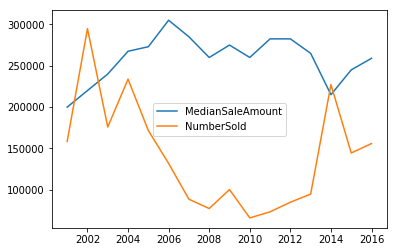

In [159]:
combined_sales_and_median_sale_amount_timeseries('Connecticut', 5).plot()

I don't know if this provides much insight, though.

In [ ]:
sale_count_timeseries().plot() # Defaults to CT

In [ ]:
sale_count_timeseries()

In [99]:
sale_count_ts_all_towns
ct_towns_recovered_sales = sale_count_ts_all_towns.copy()
ct_towns_recovered_sales['Town'] = ct_towns_recovered_sales.index
ct_towns_recovered_sales['MeanPreRecessionSaleCount'] = (ct_towns_recovered_sales[2001] + ct_towns_recovered_sales[2002] \
    + ct_towns_recovered_sales[2003] + ct_towns_recovered_sales[2004] + ct_towns_recovered_sales[2005] \
    + ct_towns_recovered_sales[2006]) / 6

In [61]:
ct_towns_recovered_sales.sort_values('MeanPreRecessionSaleCount', ascending=False).head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Town,MeanPreRecessionSaleCount
Connecticut,31699,58972,35196,46767,34342,26388,17737,15488,20069,13217,14693,17009,18979,45461,28907,31196,Connecticut,38894.000000
Bridgeport,1546,2927,0,2200,1916,1170,458,0,333,237,365,308,480,1488,0,874,Bridgeport,1626.500000
Stamford,1216,2091,1344,1360,1067,0,0,448,558,300,488,0,689,1577,1436,1434,Stamford,1179.666667
New Haven,1,2212,1322,1505,1234,0,467,297,315,223,349,203,305,742,531,0,New Haven,1045.666667
West Hartford,1095,1926,1115,1081,997,0,672,567,628,502,0,693,695,981,884,0,West Hartford,1035.666667


In [62]:
ct_towns_recovered_sales['2015PctOfPreRecessionMean'] = \
        ct_towns_recovered_sales[2015] / ct_towns_recovered_sales['MeanPreRecessionSaleCount']

In [63]:
ct_towns_recovered_sales['2016PctOfPreRecessionMean'] = \
        ct_towns_recovered_sales[2016] / ct_towns_recovered_sales['MeanPreRecessionSaleCount']

In [64]:
ct_towns_recovered_sales.head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Town,MeanPreRecessionSaleCount,2015PctOfPreRecessionMean,2016PctOfPreRecessionMean
Connecticut,31699,58972,35196,46767,34342,26388,17737,15488,20069,13217,14693,17009,18979,45461,28907,31196,Connecticut,38894.000000,0.743225,0.802077
Ansonia,258,0,249,295,268,173,0,82,97,81,82,0,120,252,122,137,Ansonia,207.166667,0.588898,0.661303
Ashford,66,0,30,64,56,52,0,31,26,18,0,28,28,45,40,0,Ashford,44.666667,0.895522,0.000000
Avon,246,561,0,341,280,228,190,19,164,172,198,218,0,401,332,340,Avon,276.000000,1.202899,1.231884
Barkhamsted,48,76,0,48,35,36,24,0,19,15,12,19,0,51,28,33,Barkhamsted,40.500000,0.691358,0.814815


In [65]:
ct_towns_recovered_sales.sort_values('2016PctOfPreRecessionMean', ascending=False).head(10)

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,Town,MeanPreRecessionSaleCount,2015PctOfPreRecessionMean,2016PctOfPreRecessionMean
Southbury,208,0,204,243,219,143,0,77,140,0,84,0,115,440,404,463,Southbury,169.500000,2.383481,2.731563
Branford,239,0,273,0,192,203,158,107,0,78,98,113,131,0,284,334,Branford,151.166667,1.878721,2.209482
South Windsor,279,0,217,290,226,208,0,162,182,176,202,0,207,404,371,400,South Windsor,203.333333,1.824590,1.967213
Pomfret,38,61,31,0,26,26,27,19,0,15,21,24,23,52,0,54,Pomfret,30.333333,0.000000,1.780220
Farmington,315,1,252,287,275,240,0,142,162,108,179,37,221,418,369,400,Farmington,228.333333,1.616058,1.751825
Rocky Hill,152,260,0,148,133,122,88,0,75,50,71,70,0,255,258,229,Rocky Hill,135.833333,1.899387,1.685890
East Windsor,87,0,126,124,100,102,0,65,62,50,58,0,81,182,124,148,East Windsor,89.833333,1.380334,1.647495
Cromwell,146,0,138,138,154,144,0,80,90,98,82,0,65,226,184,195,Cromwell,120.000000,1.533333,1.625000
Danbury,865,0,677,847,688,534,0,281,322,299,311,0,411,941,804,884,Danbury,601.833333,1.335918,1.468845
Canton,144,210,0,120,122,118,84,3,80,59,90,107,0,182,139,172,Canton,119.000000,1.168067,1.445378


In [ ]:
# Let's look at some towns that have "recovered" the number of yearly sales
ct_recovered_sale_numbers = ct_towns_recovered_sales[ct_towns_recovered_sales['2016PctOfPreRecessionMean'] > 1]

In [ ]:
ct_recovered_sale_numbers[0:2].transpose()[0:-3].plot()

In [ ]:
# Now let's look at some places that have not "recovered" in this way
ct_not_recovered_sale_numbers = ct_towns_recovered_sales[ct_towns_recovered_sales['2016PctOfPreRecessionMean'] < 1]

In [ ]:
ct_not_recovered_sale_numbers[1:4].transpose()[0:-3].plot()

In [ ]:
# Where have sales really grown?
ct_recovered_sale_numbers.sort_values('2016PctOfPreRecessionMean', ascending=False)[0:3].transpose()[0:-3].plot()

In [ ]:
# Where have sales really fallen?
ct_not_recovered_sale_numbers.sort_values('2016PctOfPreRecessionMean', ascending=True)[0:3].transpose()[0:-3].plot()

In [ ]:
ct_not_recovered_sale_numbers.sort_values('2016PctOfPreRecessionMean', ascending=True)[4:7].transpose()[0:-3].plot()

#### What this illustrates
* Many towns in CT have reached sale numbers in 2016 that are equal to or geater than what they were from 2002-2006, before the recession... And many are way behind those numbers.
* __I want to see__ if there happens to be a correlation between a critical number of these towns and the median sale amount.

### Load in population and median income data for each town to help with town subsetting.
* Town-by-town population estimates come from CT DPH: https://portal.ct.gov/DPH/Health-Information-Systems--Reporting/Population/Annual-Town-and-County-Population-for-Connecticut
* Median income data from Census Bureau via CT Data Collaborative http://data.ctdata.org/dataset/median-household-income-by-town

#### Gather and clean town population data

In [19]:
raw_town_pop_data = pd.read_excel("https://portal.ct.gov/-/media/Departments-and-Agencies/DPH/Population/Town-Pop/pop_towns2016xlsx.xlsx?la=en",
                             skiprows=10)

In [20]:
raw_town_pop_data.head()

,Town,Est. Pop.,Town.1,Est. Pop..1,Town.2,Est. Pop..2,Town.3,Est. Pop..3
0,Andover,3252.0,East Hartford,50237.0,Monroe,19658.0,Sherman,3641.0
1,Ansonia,18732.0,East Haven,28807.0,Montville,19231.0,Simsbury,24407.0
2,Ashford,4236.0,East Lyme,18886.0,Morris,2279.0,Somers,11092.0
3,Avon,18364.0,Easton,7561.0,Naugatuck,31392.0,Southbury,19572.0
4,Barkhamsted,3664.0,East Windsor,11355.0,New Britain,72558.0,Southington,43685.0


In [21]:
raw_town_pop_data.tail()

,Town,Est. Pop.,Town.1,Est. Pop..1,Town.2,Est. Pop..2,Town.3,Est. Pop..3
46,Source:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47,Annual Estimates of the Resident Population: A...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
49,Citation:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50,"Backus, K, Mueller, LM (2017) Town-level Popul...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
raw_town_pop_data.columns

Index(['Town', 'Est. Pop.', 'Town.1', 'Est. Pop..1', 'Town.2', 'Est. Pop..2',
       'Town.3', 'Est. Pop..3'],
      dtype='object')

In [23]:
# Clean town population data by separating the pairs of columns and concatenate them into one datafame
def clean_town_population_df(raw_df):
    """
    Returns a clean version of the raw town population df.
    """
    clean_df = raw_df.copy()
    
    # Split up column pairs
    town_pop_section_1 = clean_df[['Town', 'Est. Pop.']]
    town_pop_section_2 = clean_df[['Town.1', 'Est. Pop..1']]
    town_pop_section_3 = clean_df[['Town.2', 'Est. Pop..2']]
    town_pop_section_4 = clean_df[['Town.3', 'Est. Pop..3']]
    
    # Trim off the NaN rows at the end of each section
    town_pop_section_1 = town_pop_section_1[0:-9]
    town_pop_section_2 = town_pop_section_2[0:-9]
    town_pop_section_3 = town_pop_section_3[0:-9]
    town_pop_section_4 = town_pop_section_4[0:-8]
    
    # Fix column names in order to concatenate properly
    columns = ['Town', 'Population']
    town_pop_section_1.columns = columns
    town_pop_section_2.columns = columns
    town_pop_section_3.columns = columns
    town_pop_section_4.columns = columns
    
    clean_df = pd.concat([town_pop_section_1, town_pop_section_2, town_pop_section_3, town_pop_section_4]).reset_index(drop=True)


    for index in clean_df.index:
        # remove commas
        clean_df.loc[index, 'Population'] = str(clean_df.iloc[index]['Population']).replace(',','')
    
    clean_df['Population'] = clean_df['Population'].astype(float)
    
    return clean_df

In [24]:
town_pop_df = clean_town_population_df(raw_town_pop_data)
town_pop_df.head(10)
town_pop_df[town_pop_df['Town'] == 'Norwalk']

,Town,Population
102,Norwalk,88438.0


#### Gather and clean town median income data

In [25]:
raw_town_income_data = pd.read_csv("http://data.ctdata.org/dataset/68296d39-d0f7-4e2d-ba0e-98a3463ab58f/resource/1a962569-c6b3-4031-b7b1-f051e9c12379/download/median-household-income-town-2016.csv")

In [26]:
raw_town_income_data.head()

,Town,FIPS,Year,Race/Ethnicity,Measure Type,Variable,Value
0,Andover,901301080,2005-2009,All,Number,Margins of Error,9003.00
1,Andover,901301080,2005-2009,All,Number,Median Household Income,84757.00
2,Andover,901301080,2005-2009,All,Ratio to State Median,Margins of Error,0.11
3,Andover,901301080,2005-2009,All,Ratio to State Median,Median Household Income,1.25
4,Andover,901301080,2005-2009,American Indian and Alaska Native Alone,Number,Margins of Error,-9999.00


In [27]:
raw_town_income_data['Year'].unique()

array(['2005-2009', '2006-2010', '2007-2011', '2008-2012', '2009-2013',
       '2010-2014', '2011-2015', '2012-2016'], dtype=object)

In [28]:
def clean_town_income_df(raw_df):
    """
    Returns a clean version of raw town income data.
    Grabs info for each town where Race/Ethnicity = All, Measure Type = Number, Variable = Median Household Income,
    and Year = 2012-2016.
    """
    clean_df = raw_df.copy()
    
    # Grab only select info
    clean_df = clean_df[(clean_df['Race/Ethnicity'] == 'All') & (clean_df['Year'] == '2012-2016')
                       & (clean_df['Measure Type'] == 'Number') & (clean_df['Variable'] == 'Median Household Income')]
    
    # Put Connecticut at the top of the dataframe while maintaining alphabetical order otherwise
    ct_row = clean_df[clean_df['Town'] == 'Connecticut'] # Grab CT row
    clean_df = clean_df[clean_df['Town'] != 'Connecticut'] # Remove it from middle of df
    clean_df = pd.concat([ct_row, clean_df]) # Add CT back to top
    
    # Drop unwanted columns
    clean_df = clean_df[['Town', 'FIPS', 'Value']]
    
    # Rename columns
    clean_df.columns = ['Town', 'FIPS', 'MedianHouseholdIncome']
    
    return clean_df.reset_index(drop=True)

In [29]:
town_income_df = clean_town_income_df(raw_town_income_data)

In [30]:
town_income_df.head(8)

,Town,FIPS,MedianHouseholdIncome
0,Connecticut,9,71755.0
1,Andover,901301080,100724.0
2,Ansonia,900901220,43386.0
3,Ashford,901501430,78313.0
4,Avon,900302060,124608.0
5,Barkhamsted,900502760,104899.0
6,Beacon Falls,900903250,84570.0
7,Berlin,900304300,93750.0


#### Join town median income and population data to town_df

In [31]:
def add_population_and_income_data(df, town_pop, town_income):
    """
    Assuming df has Town names, will join data from town_income_df and town_population_df by town.
    Specifically, grabs 'Population' from town_pop and 'MedianHouseholdIncome', as well as 'FIPS', from town_income.
    """
    new_df = df.copy()
    new_df = df.merge(right = town_pop[['Town','Population']], on='Town')
    new_df = new_df.merge(right = town_income[['Town','MedianHouseholdIncome','FIPS']], on = 'Town')
    return new_df

In [32]:
town_df_copy = add_population_and_income_data(town_df, town_pop_df, town_income_df)
town_df_copy.head(7)

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio,Population,MedianHouseholdIncome,FIPS
0,Ansonia,112600,207000,1.4554,23600,312600,20100,710000,0.271374,129.145,18732.0,43386.0,900901220
1,Ashford,121700,199900,0.904245,27640,1094690,40000,4.025e+06,0.256527,124.14,4236.0,78313.0,901501430
2,Avon,266180,417500,0.791192,3500,2896370,7500,5e+06,0.180948,112.09,18364.0,124608.0,900302060
3,Barkhamsted,139195,238250,0.896428,22160,440750,15000,700000,0.408118,155.267,3664.0,104899.0,900502760
4,Berlin,155900,253500,0.759083,0,1571000,4000,1.35608e+06,0,100.88,20499.0,93750.0,900304300
5,Bethany,207570,341000,0.868738,17210,678960,12000,1.38e+06,0.304681,137.227,5488.0,106058.0,900904580
6,Bethel,196480,335000,0.877093,18200,799680,25000,1.4e+06,0.0398337,84.6953,19627.0,94292.0,900104720


In [33]:
town_df_copy.head()

,Town,MedianAssessedValue,MedianSaleAmount,MedianSalesRatio,MinAssessedValue,MaxAssessedValue,MinSaleAmount,MaxSaleAmount,MinSalesRatio,MaxSalesRatio,Population,MedianHouseholdIncome,FIPS
0,Ansonia,112600,207000,1.4554,23600,312600,20100,710000,0.271374,129.145,18732.0,43386.0,900901220
1,Ashford,121700,199900,0.904245,27640,1094690,40000,4.025e+06,0.256527,124.14,4236.0,78313.0,901501430
2,Avon,266180,417500,0.791192,3500,2896370,7500,5e+06,0.180948,112.09,18364.0,124608.0,900302060
3,Barkhamsted,139195,238250,0.896428,22160,440750,15000,700000,0.408118,155.267,3664.0,104899.0,900502760
4,Berlin,155900,253500,0.759083,0,1571000,4000,1.35608e+06,0,100.88,20499.0,93750.0,900304300


In [34]:
# Reorder columns for better readability
town_df_copy = town_df_copy[['Town', 'FIPS', 'Population', 
                   'MedianHouseholdIncome', 'MedianSaleAmount', 'MaxSaleAmount', 'MinSaleAmount',
                   'MedianAssessedValue', 'MaxAssessedValue', 'MinAssessedValue', 'MaxSalesRatio', 'MinSalesRatio']]

In [36]:
%store town_df_copy

Stored 'town_df_copy' (DataFrame)


In [37]:
town_df = town_df_copy

### Subset towns by population

In [40]:
town_df.head()

,Town,FIPS,Population,MedianHouseholdIncome,MedianSaleAmount,MaxSaleAmount,MinSaleAmount,MedianAssessedValue,MaxAssessedValue,MinAssessedValue,MaxSalesRatio,MinSalesRatio
0,Ansonia,900901220,18732.0,43386.0,207000,710000,20100,112600,312600,23600,129.145,0.271374
1,Ashford,901501430,4236.0,78313.0,199900,4.025e+06,40000,121700,1094690,27640,124.14,0.256527
2,Avon,900302060,18364.0,124608.0,417500,5e+06,7500,266180,2896370,3500,112.09,0.180948
3,Barkhamsted,900502760,3664.0,104899.0,238250,700000,15000,139195,440750,22160,155.267,0.408118
4,Berlin,900304300,20499.0,93750.0,253500,1.35608e+06,4000,155900,1571000,0,100.88,0


In [41]:
town_df['Population'].describe()

count       169.00000
mean      21162.43787
std       25507.22165
min         840.00000
25%        5433.00000
50%       12631.00000
75%       25737.00000
max      145936.00000
Name: Population, dtype: float64

In [43]:
len(tiny_town) + len(small_town) + len(medium_town) + len(large_town)

169

In [66]:
town_df_recovery = town_df_copy.copy()

In [76]:
town_df_recovery = town_df_recovery.merge(right= ct_towns_recovered_sales[['Town', '2015PctOfPreRecessionMean', '2016PctOfPreRecessionMean']],
                      on = 'Town')

In [85]:
town_df_recovery[['Town', 'Population', '2015PctOfPreRecessionMean']].head()

,Town,Population,2015PctOfPreRecessionMean
0,Ansonia,18732.0,0.588898
1,Ashford,4236.0,0.895522
2,Avon,18364.0,1.202899
3,Barkhamsted,3664.0,0.691358
4,Berlin,20499.0,1.287834


In [86]:
tiny_town = town_df_recovery[town_df_recovery['Population'].isin(range(0,5433))] # 25th percentile
small_town = town_df_recovery[town_df_recovery['Population'].isin(range(5433,12631))] # 25th-50th percentile
medium_town = town_df_recovery[town_df_recovery['Population'].isin(range(12631,25737))] # 50th-7th percentile
large_town = town_df_recovery[town_df_recovery['Population'].isin(range(25737,200000))] #75th percentile to max

In [91]:
tiny_town[['Town', 'Population', '2016PctOfPreRecessionMean']].describe().iloc[5]

Population                   2906.000000
2016PctOfPreRecessionMean       0.892822
Name: 50%, dtype: float64

In [92]:
small_town[['Town', 'Population', '2016PctOfPreRecessionMean']].describe().iloc[5]

Population                   8932.500000
2016PctOfPreRecessionMean       0.979686
Name: 50%, dtype: float64

In [95]:
medium_town[['Town', 'Population', '2016PctOfPreRecessionMean']].describe().iloc[5]

Population                   18462.000000
2016PctOfPreRecessionMean        1.001363
Name: 50%, dtype: float64

In [96]:
large_town[['Town', 'Population', '2016PctOfPreRecessionMean']].describe().iloc[5]

Population                   44368.000000
2016PctOfPreRecessionMean        0.823873
Name: 50%, dtype: float64

In [97]:
# Small and medium-sized towns seem to be doing the best in terms of SALE NUMBERS RECOVERY.

In [98]:
# What about MedianSaleAmount?

In [108]:
combine_sales_and_median_sale_amount()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
MedianSaleAmount,200000.0,220000.0,240000.0,267500.0,273000.0,305000.0,285000.0,260000.0,275000.0,260000.0,282500.0,282500.0,265000.0,215000.0,245000.0,259000.0
NumberSold,31699.0,58972.0,35196.0,46767.0,34342.0,26388.0,17737.0,15488.0,20069.0,13217.0,14693.0,17009.0,18979.0,45461.0,28907.0,31196.0


In [220]:
# Make a dataframe that measures recovery to pre-recession Median Sale Amount
ct_towns_recovered_saleamount = saleamount_ts_all.copy()

# Need to have a more detailed way to sum rows since NAs should not be included, and we should therefore calculate
# mean differently
def calculate_mean_pre_recession_sale_amount(df):
    """
    Returs a copy of df with a column called 'MeanPreRecessionSaleAmount'
    """
    new_df = df.copy()
    new_df['MeanPreRecessionSaleAmount'] = -1
    
    # Iterate through every town
    for index in new_df.index:
        list_of_values = []
        
        # Iterate through every pre-recession year (excluding 2006, which is when the tanking begins)
        for year in range (2001, 2006):
            value = new_df.loc[index, year] # Grab current value
            if str(value) not in ['nan', '-1']:
                list_of_values += [value]
                
        # Update MeanPreRecessionSaleAmount
        mean = sum(list_of_values) / len(list_of_values)
        new_df.loc[index, 'MeanPreRecessionSaleAmount'] = mean
        
    return new_df

In [222]:
calculate_mean_pre_recession_sale_amount(ct_towns_recovered_saleamount).head()

,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,MeanPreRecessionSaleAmount
Connecticut,200000.000,220000.000,240000.000,267500.000,273000.000,305000.000,285000.000,260000.000,275000.000,260000.000,282500.000,282500.000,265000.000,215000.000,245000.000,259000.000,240100.000
Ansonia,153000.000,nan,216300.000,240000.000,260000.000,254950.000,nan,230000.000,210000.000,183000.000,180500.000,nan,185000.000,150500.000,190950.000,195000.000,217325.000
Ashford,144500.000,nan,147250.000,200575.000,230950.000,259950.000,nan,216240.000,231250.000,229000.000,nan,188500.000,180700.000,179000.000,206500.000,nan,180818.750
Avon,355000.000,406859.000,nan,465000.000,495500.000,496250.000,469750.000,520000.000,450000.000,462500.000,492000.000,477500.000,nan,349000.000,380000.000,353500.000,430589.750
Barkhamsted,185000.000,210000.000,nan,254500.000,265500.000,259500.000,247500.000,nan,239800.000,245000.000,247500.000,208900.000,nan,225000.000,250000.000,265000.000,228750.000


In [223]:
def calculate_saleamount_pct_recovery(df):
    """
    Returns a copy of df with columns '2015PctOfPreRecessionSaleAmount' and '2016PctOfPreRecessionSaleAmount',
    which are equal to 2015 median sale amount / mean pre recession sale amount
    """
    new_df = df.copy()
    new_df['2015PctOfPreRecessionSaleAmount'] = new_df[2015] / new_df['MeanPreRecessionSaleAmount']
    new_df['2016PctOfPreRecessionSaleAmount'] = new_df[2016] / new_df['MeanPreRecessionSaleAmount']
    
    return new_df

In [233]:
def sale_amount_recovery_dataframe():
    """
    Returns a dataframe that includes a time series of each town's median sale amount, MIN_YEAR to MAX_YEAR,
    as well as three additional columns to calculate the mean sale amount pre-recession, and the 2015- and 2016
    recovery rates.
    
    Uses two helpe functions: calculate_saleamount_pct_recovery() and calculate_mean_pre_recession_sale_amount.
    Also uses a copy of a global variable called saleamount_ts_all, because the function that produces this variable
    takes a long time to run.
    """
    sale_data = saleamount_ts_all.copy()
    sale_data['Town'] = sale_data.index
    return calculate_saleamount_pct_recovery(calculate_mean_pre_recession_sale_amount(sale_data))

In [235]:
# Now join this info with town_df_recovery
sale_recovery = sale_amount_recovery_dataframe()
town_df_recovery = town_df_recovery.merge(right=sale_recovery, on="Town")

In [237]:
town_df_recovery.head()

,Town,FIPS,Population,MedianHouseholdIncome,MedianSaleAmount,MaxSaleAmount,MinSaleAmount,MedianAssessedValue,MaxAssessedValue,MinAssessedValue,...,2010,2011,2012,2013,2014,2015,2016,MeanPreRecessionSaleAmount,2015PctOfPreRecessionSaleAmount,2016PctOfPreRecessionSaleAmount
0,Ansonia,900901220,18732.000,43386.000,207000.000,710000.000,20100.000,112600.000,312600,23600,...,183000.000,180500.000,nan,185000.000,150500.000,190950.000,195000.000,217325.000,0.879,0.897
1,Ashford,901501430,4236.000,78313.000,199900.000,4025000.000,40000.000,121700.000,1094690,27640,...,229000.000,nan,188500.000,180700.000,179000.000,206500.000,nan,180818.750,1.142,nan
2,Avon,900302060,18364.000,124608.000,417500.000,5000000.000,7500.000,266180.000,2896370,3500,...,462500.000,492000.000,477500.000,nan,349000.000,380000.000,353500.000,430589.750,0.883,0.821
3,Barkhamsted,900502760,3664.000,104899.000,238250.000,700000.000,15000.000,139195.000,440750,22160,...,245000.000,247500.000,208900.000,nan,225000.000,250000.000,265000.000,228750.000,1.093,1.158
4,Berlin,900304300,20499.000,93750.000,253500.000,1356081.000,4000.000,155900.000,1571000,0,...,249000.000,253950.000,nan,256500.000,243500.000,265000.000,259000.000,242812.500,1.091,1.067
